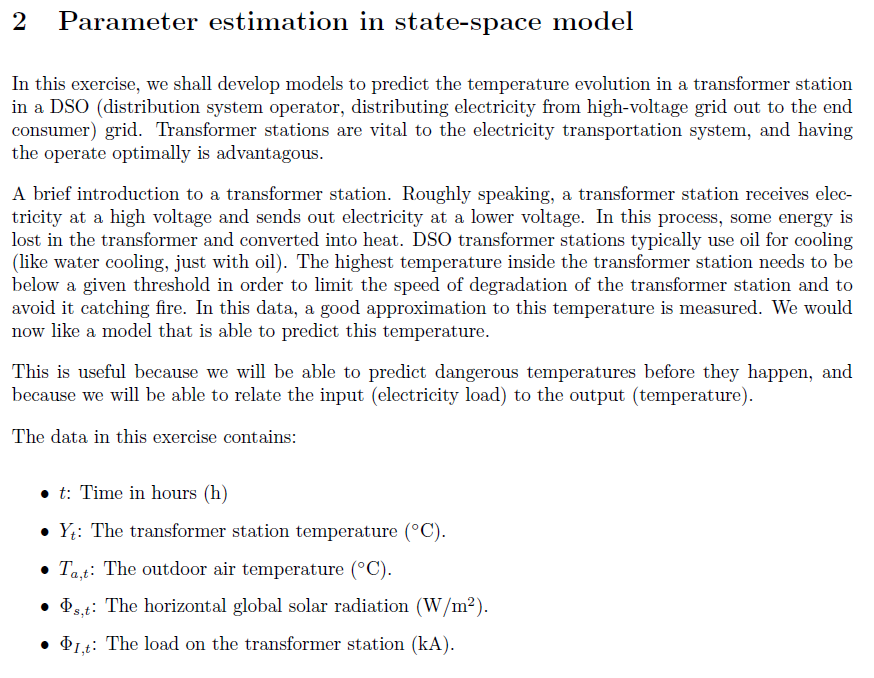

In [ ]:
# Libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm
from scipy.optimize import minimize

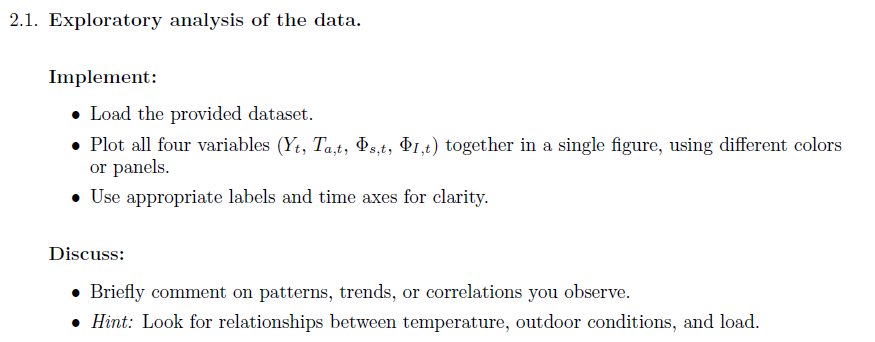

### Load dataset

In [2]:
df=pd.read_csv('transformer_data.csv')

print(df.head())

print(df.info())


   time          Y        Ta    S          I
0     1  23.496733  7.083333  0.0  15.899541
1     2  22.720333  7.116667  0.0  15.861768
2     3  22.052700  7.216667  0.0  16.121469
3     4  21.538050  7.250000  0.0  15.447628
4     5  20.995033  7.316667  0.0  16.258319
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    168 non-null    int64  
 1   Y       168 non-null    float64
 2   Ta      168 non-null    float64
 3   S       168 non-null    float64
 4   I       168 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 6.7 KB
None


### Plot dataset

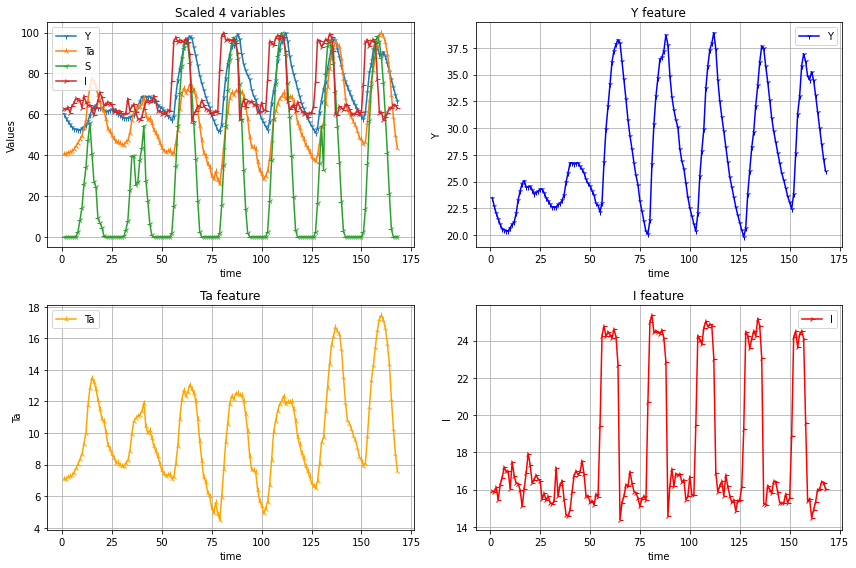

In [3]:
# Creating subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

#plt.figure(figsize=(8, 5))
axes[0][0].plot(df['time'], df['Y']*(100/max(df['Y'])), label='Y', marker='1')
axes[0][0].plot(df['time'], df['Ta']*(100/max(df['Ta'])), label='Ta', marker='2')
axes[0][0].plot(df['time'], df['S']*(100/max(df['S'])), label='S', marker='3')
axes[0][0].plot(df['time'], df['I']*(100/max(df['I'])), label='I', marker='4')
axes[0][0].set_xlabel('time')
axes[0][0].set_ylabel('Values')
axes[0][0].set_title('Scaled 4 variables')
axes[0][0].legend()
axes[0][0].grid()

# Plotting the first subplot
axes[0][1].plot(df['time'], df['Y'], label='Y', marker='1', color='blue')
axes[0][1].set_title('Y feature')
axes[0][1].set_xlabel('time')
axes[0][1].set_ylabel('Y')
axes[0][1].grid()
axes[0][1].legend()

# Plotting the second subplot 
axes[1][0].plot(df['time'], df['Ta'], label='Ta', marker='2', color='orange')
axes[1][0].set_title('Ta feature')
axes[1][0].set_xlabel('time')
axes[1][0].set_ylabel('Ta')
axes[1][0].grid()
axes[1][0].legend()

# Plotting the third subplot 
axes[1][1].plot(df['time'], df['I'], label='I', marker='4', color='red')
axes[1][1].set_title('I feature')
axes[1][1].set_xlabel('time')
axes[1][1].set_ylabel('I')
axes[1][1].grid()
axes[1][1].legend()

# Adjusting layout for better visualization
plt.tight_layout()
plt.show()

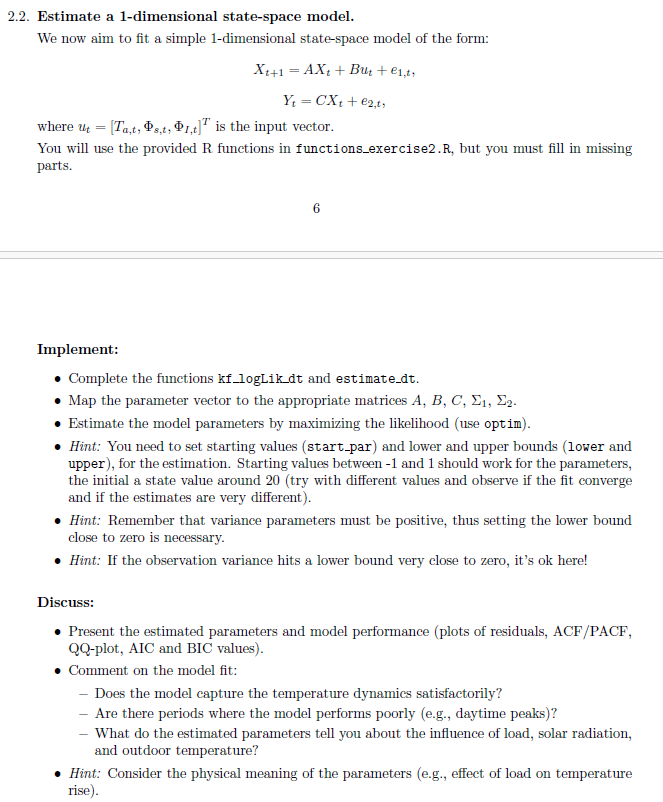

In [ ]:

def kf_logLik_dt(par, df):
    """
    par: vector of parameters
    df: DataFrame with observations and inputs as columns (Y, Ta, S, I)
    par: Could be on the form [A, B1, B2, B3, B4, Q, R]
    """

    # Define matrices
    A = np.array([[par[0]]])  # Transition matrix
    B = np.array([[par[1], par[2], par[3]]])  # Input matrix
    Sigma1lt = np.array([[par[4]]])  # Lower-triangle of system covariance matrix
    Sigma1 = Sigma1lt @ Sigma1lt.T  # System covariance matrix (symmetric positive definite)
    C = np.array([[1]])  # Observation matrix
    Sigma2 = np.array([[par[5]]])  # Observation noise covariance matrix
    X0 = np.array([[20]]) # Initial state

    # Variables
    obs_cols = ["Y"]  # Observation column names
    input_cols = ["Ta", "S", "I"]  # Input column names

    # Pull out data
    Y = df[obs_cols].to_numpy()  # m×T
    U = df[input_cols].to_numpy()  # p×T
    Tn = len(df)

    # Init
    n = A.shape[0]
    x_est = X0  # Start state from initial state
    P_est = np.eye(n) * 1e1  # X0 prior covariance
    logLik = 0

    for t in range(Tn):
        # Prediction step
        x_pred = A @ x_est + B @ U[t, :].reshape(-1, 1)
        P_pred = A @ P_est @ A.T + Sigma1

        # Innovation step
        y_pred = C @ x_pred
        S_t = C @ P_pred @ C.T + Sigma2
        innov = Y[t, :].reshape(-1, 1) - y_pred

        # Log-likelihood contribution
        logLik -= 0.5 * (np.log(2 * np.pi * np.linalg.det(S_t)) + innov.T @ np.linalg.solve(S_t, innov))

        # Update step
        K_t = P_pred @ C.T @ np.linalg.inv(S_t)
        x_est = x_pred + K_t @ innov
        P_est = P_pred - K_t @ C @ P_pred

    return float(logLik)

def estimate_dt(start_par, df, lower=None, upper=None):
    """
    Optimizer wrapper to estimate parameters.
    """
    def negLL(par):
        return -kf_logLik_dt(par, df)

    bounds = None
    if lower is not None and upper is not None:
        bounds = [(l, u) for l, u in zip(lower, upper)]

    result = minimize(
        fun=negLL,
        x0=start_par,
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 1000, 'disp': True}
    )
    return result



### Explanation of the Missing Parts:
1. **Parameter Mapping**:
   - `A`: Transition matrix (1x1).
   - `B`: Input matrix (1x4) for the inputs `Ta`, `S`, `I`, and `Phi`.
   - `Q`: System covariance matrix (1x1).
   - `C`: Observation matrix (1x1), assumed to be `[1]` since `Y` is directly observed.
   - `R`: Observation noise covariance matrix (1x1).

2. **Prediction Step**:
   - `x_pred = A @ x_est + B @ U[t, :]`: Predict the next state.
   - `P_pred = A @ P_est @ A.T + Q`: Predict the next state covariance.

3. **Innovation Step**:
   - `y_pred = C @ x_pred`: Predict the observation.
   - `S_t = C @ P_pred @ C.T + R`: Compute the predicted observation covariance.
   - `innov = Y[t, :] - y_pred`: Compute the innovation (prediction error).

4. **Log-Likelihood Contribution**:
   - The log-likelihood is updated using the innovation and its covariance.

5. **Update Step**:
   - `K_t`: Kalman gain.
   - `x_est`: Updated state estimate.
   - `P_est`: Updated state covariance.

6. **Optimizer Wrapper**:
   - Uses `scipy.optimize.minimize` with the `L-BFGS-B` method for bounded optimization.

### Notes:
- Replace `start_par`, `lower`, and `upper` with appropriate values based on your problem.
- Ensure the input DataFrame `df` has the required columns (`Y`, `Ta`, `S`, `I`, `Phi`).
- The initial state (`x_est`) is set to 20 as per the hint in the instructions. Adjust if needed.

Estimated Parameters: [ 8.01107195e-01  1.01737295e-01  2.87123032e-03  2.13474867e-01
 -6.44582242e-01  1.00000000e-06  1.00000000e-02]


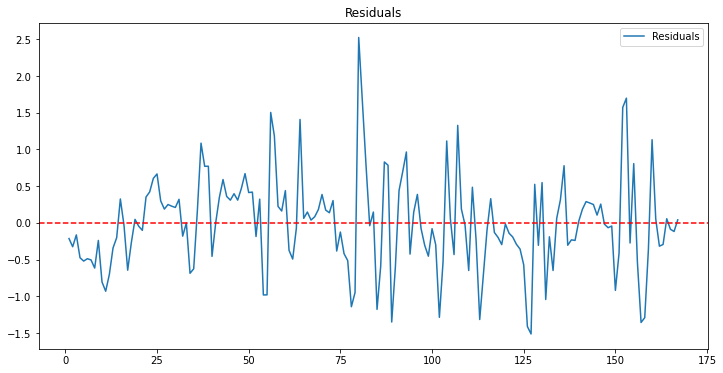

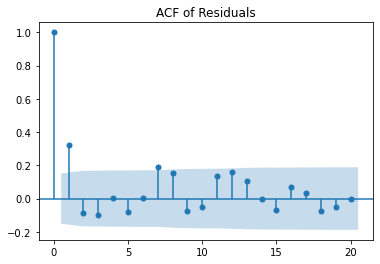

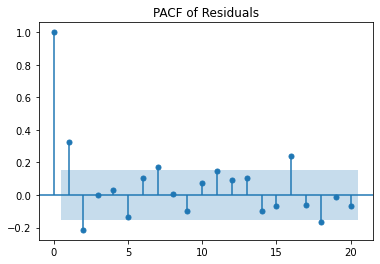

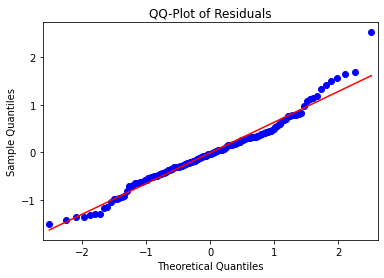

AIC: -318.6211306496063
BIC: -296.79517396268903


In [ ]:

# Function to calculate AIC and BIC
def calculate_aic_bic(log_likelihood, num_params, num_obs):
    aic = 2 * num_params - 2 * log_likelihood
    bic = np.log(num_obs) * num_params - 2 * log_likelihood
    return aic, bic

# Function to evaluate model performance
def evaluate_model(df, estimated_params):
    # Extract residuals
    residuals = df['Y'] - (estimated_params[0] * df['Y'].shift(1) + 
                           estimated_params[1] * df['Ta'] + 
                           estimated_params[2] * df['S'] + 
                           estimated_params[3] * df['I'] )
    residuals = residuals.dropna()

    # Plot residuals
    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label='Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals')
    plt.legend()
    plt.show()

    # ACF and PACF plots
    plot_acf(residuals, lags=20, title='ACF of Residuals')
    plot_pacf(residuals, lags=20, title='PACF of Residuals')
    plt.show()

    # QQ-plot
    qqplot(residuals, line='s')
    plt.title('QQ-Plot of Residuals')
    plt.show()

    # Calculate AIC and BIC
    log_likelihood = -kf_logLik_dt(estimated_params, df)
    num_params = len(estimated_params)
    num_obs = len(residuals)
    aic, bic = calculate_aic_bic(log_likelihood, num_params, num_obs)

    print(f"AIC: {aic}")
    print(f"BIC: {bic}")

# Example usage
# Define starting parameters and bounds
start_par = [0.5, 0.1, 0.1, 0.1, 0.1, 0.01, 0.01]  # Example starting values
lower_bounds = [-1, -1, -1, -1, -1, 1e-6, 1e-6]
upper_bounds = [1, 1, 1, 1, 1, 10, 10]

# Estimate parameters
result = estimate_dt(start_par, df, lower=lower_bounds, upper=upper_bounds)
estimated_params = result.x
print("Estimated Parameters:", estimated_params)

# Evaluate model performance
evaluate_model(df, estimated_params)

In the code, the starting parameters (`start_par`) and bounds (`lower_bounds` and `upper_bounds`) are defined as follows:

### Starting Parameters (`start_par`)
```python
start_par = [0.5, 0.1, 0.1, 0.1, 0.1, 0.01, 0.01]  # Example starting values
```
- This is a list of initial guesses for the parameters to be estimated. 
- The parameters correspond to:
  1. `A` (Transition matrix coefficient)
  2. `B1` (Input matrix coefficient for `Ta`)
  3. `B2` (Input matrix coefficient for `S`)
  4. `B3` (Input matrix coefficient for `I`)
  5. `Q` (System covariance matrix component)
  6. `R` (Observation noise covariance matrix component)

### Lower Bounds (`lower_bounds`)
```python
lower_bounds = [-1, -1, -1, -1, -1, 1e-6, 1e-6]
```
- These define the minimum allowable values for each parameter during optimization.
- For example:
  - `A`, `B1`, `B2`, `B3`, and `Q` have a lower bound of `-1`.
  - `R` and `Q` have a lower bound of `1e-6` to ensure positive definiteness.

### Upper Bounds (`upper_bounds`)
```python
upper_bounds = [1, 1, 1, 1, 1, 10, 10]
```
- These define the maximum allowable values for each parameter during optimization.
- For example:
  - `A`, `B1`, `B2`, `B3`, and `Q` have an upper bound of `1`.
  - `R` and `Q` have an upper bound of `10`.
